# NFL Salary Cap Optimization by Position Group

---


# Table of Contents

1) [Business Understanding](#business_understanding)  
2) [Data Background and Limitations](#data_and_limitations)  
3) [EDA and Data Cleaning](#EDA_data_cleaning)  
4) [Modeling](#modeling)  
&nbsp;&nbsp;&nbsp;&nbsp;4a. [Baseline](#Baseline)  
&nbsp;&nbsp;&nbsp;&nbsp;4b. [Logistic Regression](#log_reg)  
&nbsp;&nbsp;&nbsp;&nbsp;4c. [Decision Tree](#dtree)  
&nbsp;&nbsp;&nbsp;&nbsp;4d. [Optimization](#func)  
5) [Feature Engineering](#feat)  
6) [Conclusions](#conc)  
&nbsp;&nbsp;&nbsp;&nbsp;6a. [Future Research](#future)  

---

# 1) Business Understanding <a class="anchor" id="business_understanding"></a>

**Business Background**: In an effort to broaden its audience, the NFL is expanding its roster from 32 teams to 34 teams with two new franchises to be located in London, UK and Vancouver, CA. We have been approached by the ownership group from one of the cities and they are eager to establish themselves as serious contenders to maximize public interest and in turn, revenue.

**Problem**: The ownership group has asked us how their team can best maximize win percentage during the regular season (17 games)  by looking at how to best allocate their available "Salary Cap" (league imposed spending limit on players).

**Goals**: Use historic nfl data to predict a team's regular season win percentage given how much they spend on diffent player position groups and provide recomendations on how they should best spend their salary cap.

---

# 2) Data Background and Limitations <a class="anchor" id="Data Background and Limitations"></a>

###  **Data Background**
   - Data scraped from <a href="https://www.spotrac.com/">spottrac.com</a>
       - Link to notebook [Scraping/Cleaning Notebook](https://github.com/chris161011/NFL_salarycap_optimization/blob/main/data/scraping_notebook.ipynb)
   - Dataset contains details about every player contract, how it affects the Salary Cap and the player's position
   - This includes players that are no longer on the team, provided their contracts still affect the Salary Cap that year  


###  **Data Limitations**
   - A paywall only lets us access 3 years (2019 - 2021)
   - Data does not factor in player performance

---

# 3) EDA and Data Cleaning <a class="anchor" id="EDA_data_cleaning"></a>
### Format:
   - **General Description** 
      - Reasoning


   - **Combine 96 scrapes from seperate web pages into 3 year based lists** 
       - Data from scrapes did not contain year or team info
   - **Add standard team abreviations and years as new columns to dataframes**
       - Required for sorting
   - **Rename first column to "Status" and overwrites column values with player status from dataframe**
       - Protects player identity and any possible bias associated with names
       - Player status is useful data while the names were arbitrary
       - Cleans up the column name for merging
   - **Filtered dataframe and clean cells**
       - Only want relevant data that is usable
   - **Pulled in regular season win % from seperate dataframe**
       - Need to pull in target data
   - **Bin player positions into groups based on player roles**
       - Many player positions are similar and 23 is too many
   - **Bin regular season win% into high, average and low based on percentiles**
       - For modeling purposes
   - **Add column for total Salary Cap per team/year**
       - Changes from year to year based on limits and team usage
   - **Group data by position group/year and bin spending based on percentiles**
       - For feature engineering       
       

Notebook with granular details [Scraping/Cleaning Notebook](https://github.com/chris161011/NFL_salarycap_optimization/blob/main/data/scraping_notebook.ipynb)

---

# 4) Modeling <a class="anchor" id="modeling"></a>  

In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.metrics import precision_score, accuracy_score, make_scorer, recall_score, plot_roc_curve, classification_report, plot_confusion_matrix, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

%matplotlib inline

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

In [2]:
# Bring in Master Dataset
FINAL_df = pd.read_csv('data/FINAL_df.csv')

In [3]:
# Filtering for the following variables as they are easily determined by ownership and we are removing team biased columns
model_df = FINAL_df[['Status', 'POS_GRP', 'pos_grp_spending', 'WIN%_GRP', 'avg_age_player']]

# Converting categorical variables for modeling
model_df = pd.get_dummies(model_df, columns=['Status', 'POS_GRP', 'pos_grp_spending','WIN%_GRP'])

In [4]:
# Train Test Split
x = model_df.drop(columns=['WIN%_GRP_high_win%', 'WIN%_GRP_avg_win%', 'WIN%_GRP_low_win%'], axis=1)
y = model_df[['WIN%_GRP_high_win%']]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=15)

# Correcting class imbalance
sm = SMOTE(random_state=15)
x_train, y_train = sm.fit_resample(x_train, y_train)

# Scale data
scale = StandardScaler()
x_train_scaled = scale.fit_transform(x_train)
x_test_scaled = scale.transform(x_test)

--- 

## &nbsp;&nbsp;&nbsp;&nbsp; 4a. Baseline Model <a class="anchor" id="Baseline"></a>

Train 0.4924996495163325
Test 0.5071542130365659


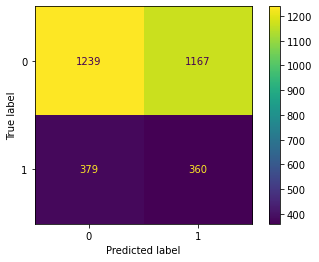

In [5]:
# Create Dummy Model
dummy_model = DummyClassifier(strategy="stratified")
dummy_model.fit(x_train_scaled, y_train)
y_hat_train = dummy_model.predict(x_train_scaled)
y_hat_test = dummy_model.predict(x_test_scaled)
print(f'Train {accuracy_score(y_train, y_hat_train)}')
print(f'Test {accuracy_score(y_test, y_hat_test)}')

# Plot confusion matrix
plot_confusion_matrix(dummy_model, x_test_scaled, y_test)

---  
## &nbsp;&nbsp;&nbsp;&nbsp; 4b. Logistic Regression <a class="anchor" id="log_reg"></a>

Train 0.6391420159820552
Test 0.6429252782193958


C:\Users\helme\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


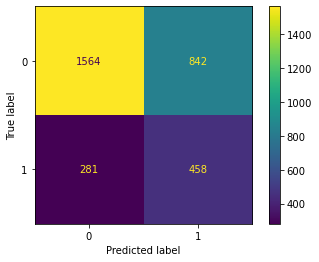

In [6]:
# Lets try a logistic regression model
lr = LogisticRegression(random_state=15)
lr.fit(x_train_scaled, y_train)
y_hat_train = lr.predict(x_train_scaled) 
y_hat_test = lr.predict(x_test_scaled) 
print(f'Train {accuracy_score(y_train, y_hat_train)}')
print(f'Test {accuracy_score(y_test, y_hat_test)}')

# Plot confusion matrix
plot_confusion_matrix(lr, x_test_scaled, y_test)

---

## &nbsp;&nbsp;&nbsp;&nbsp; 4c. Decision Tree <a class="anchor" id="dtree"></a>

Train 0.7822094490396747
Test 0.7643879173290938


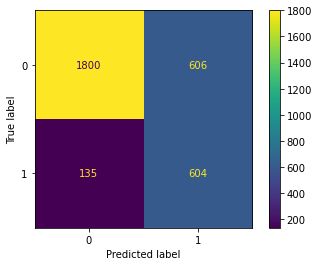

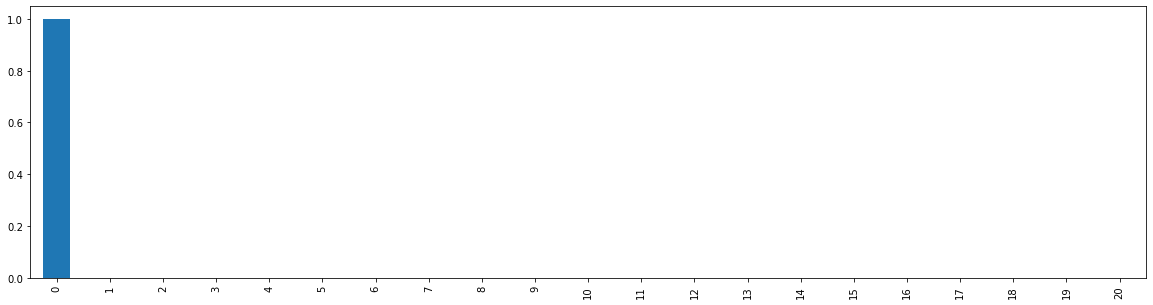

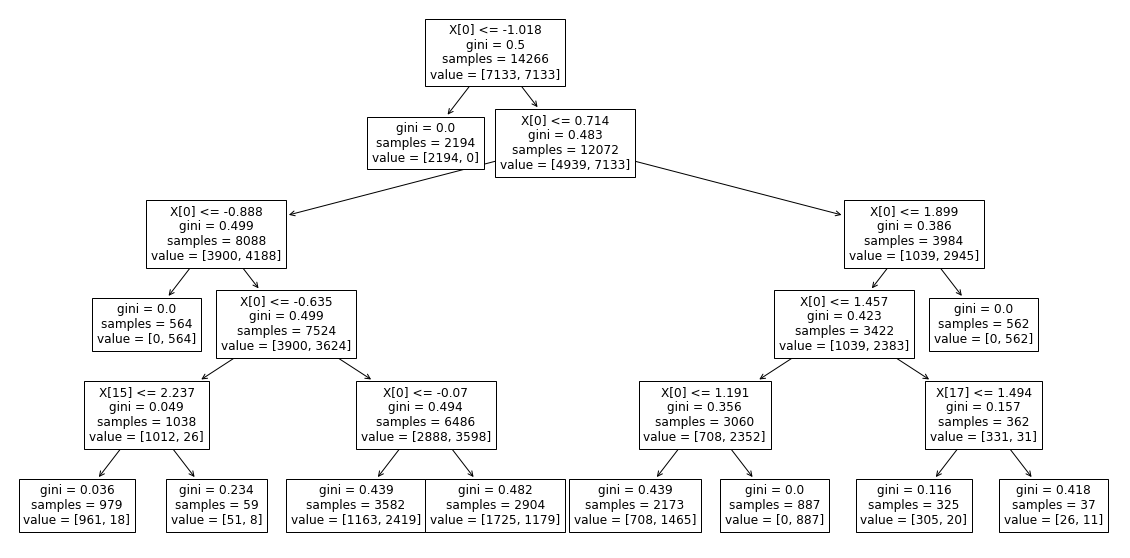

In [7]:
# Instantiated, fit, and ran basic decision tree model
clf = DecisionTreeClassifier(max_depth = 5) 
clf.fit(x_train_scaled, y_train)
y_hat_train = clf.predict(x_train_scaled)
y_hat_test = clf.predict(x_test_scaled)
print(f'Train {accuracy_score(y_train, y_hat_train)}')
print(f'Test {accuracy_score(y_test, y_hat_test)}')

# Plotted confusion matrix and ROC AUC for basic decision tree model
plot_confusion_matrix(clf, x_test_scaled, y_test);

# Plotted feature importance for basic decision tree model
ranking = clf.feature_importances_
fig, ax = plt.subplots(figsize=(20,5))
pd.Series(ranking).plot.bar(ax=ax);

# Plotted basic decision tree model
f, ax = plt.subplots(figsize=(20, 10))
plot_tree(clf);

---  
## &nbsp;&nbsp;&nbsp;&nbsp; 4d. Optimization <a class="anchor" id="func"></a>  

&nbsp;&nbsp;&nbsp;&nbsp; We achieved close enough scores with both Logistic Regression and Decision Trees that I believe it warrants optimizing both.  
&nbsp;&nbsp;&nbsp;&nbsp; First lets declare some functions to speed up the process.


In [8]:
# Function that takes in the classifier as input and returns a preproccessed pipeline.
def pipe_maker(classifier):
    
    pipe = Pipeline([('smt', SMOTE(random_state=15)),
                     ('scl', StandardScaler()),
                     ('clf', classifier(random_state=15))])
    return pipe

In [9]:
# Function that takes in a Pipeline & Parameters then returns a gridsearch object with selected parameters.
def gridsearch_maker(pipeline, params):

    return GridSearchCV(estimator=pipeline,
                        param_grid=params,
                        scoring='balanced_accuracy',
                        cv=10,
                        n_jobs=-1)

In [10]:
# Function that takes in a gridsearch, interates over the available hyperparameters and returns the parameters necessary
# to achieve the optimal accuracy score.
def best_accuracy(gridsearch):

    # Create best_accuracy object.
    best_accuracy = 0.0
    
    # Fit gridsearch to regularized data set.
    gridsearch.fit(x_train, y_train)
    
    # Print best parameters.
    print('Best paramaters are: %s' % gridsearch.best_params_)
    
    # Print best train accuracy score.
    print('Best training accuracy is: %.3f' % gridsearch.best_score_)
    
    # Prediction on test data.
    y_pred = gridsearch.predict(x_test)
    
    # Print test data accuracy with best params.
    print('Test set accuracy score with best parameters: %.3f ' % accuracy_score(y_test, y_pred))
    
    # Print confusion matrix and classification report.
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    print('accuracy score: ', accuracy_score(y_test, y_pred))
    
    # Plot confusion matrix.
    plot_confusion_matrix(gridsearch, x_test, y_test,cmap="plasma")
    plt.show()

Functions adapted from: Diane Tunnicliffe on 4/18/2022.  
Source: <a href="https://github.com/dtunnicliffe/fetal-health-classification">github.com/dtunnicliffe</a>

In [11]:
# Setting parameters options as lists
param_range = [*range(1, 11, 1)]
param_range_small = [1.0, 0.5, 0.1]

In [12]:
# Train Test Split with high win% as target
x = model_df.drop(columns=['WIN%_GRP_high_win%', 'WIN%_GRP_avg_win%', 'WIN%_GRP_low_win%'], axis=1)
y = model_df[['WIN%_GRP_high_win%']]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=15)

C:\Users\helme\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


Best paramaters are: {'clf__max_iter': 500, 'clf__penalty': 'l2', 'clf__solver': 'liblinear'}
Best training accuracy is: 0.628
Test set accuracy score with best parameters: 0.643 
[[1564  842]
 [ 281  458]]
              precision    recall  f1-score   support

           0       0.85      0.65      0.74      2406
           1       0.35      0.62      0.45       739

    accuracy                           0.64      3145
   macro avg       0.60      0.63      0.59      3145
weighted avg       0.73      0.64      0.67      3145

accuracy score:  0.6429252782193958


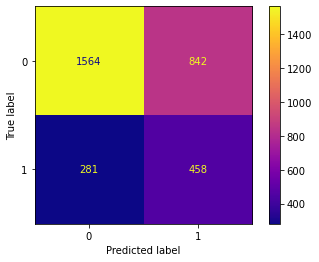

In [13]:
# Optimizing Logistic Regression
pipe_lr = pipe_maker(LogisticRegression)

gs_lr = gridsearch_maker(pipe_lr, {'clf__penalty': ['l1', 'l2'], 'clf__solver': ['liblinear', 'saga'], 'clf__max_iter': [500]})

best_accuracy(gs_lr)

Best paramaters are: {'clf__criterion': 'gini', 'clf__max_depth': 10, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 2}
Best training accuracy is: 0.927
Test set accuracy score with best parameters: 0.961 
[[2376   30]
 [  92  647]]
              precision    recall  f1-score   support

           0       0.96      0.99      0.97      2406
           1       0.96      0.88      0.91       739

    accuracy                           0.96      3145
   macro avg       0.96      0.93      0.94      3145
weighted avg       0.96      0.96      0.96      3145

accuracy score:  0.96120826709062


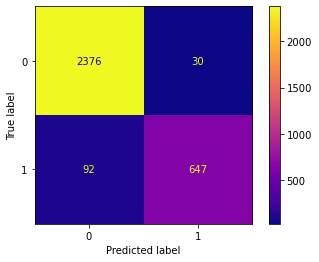

In [14]:
# Optimizing DecisionTreeClassifier
pipe_dt = pipe_maker(DecisionTreeClassifier)

# setting grid search parameters
grid_params_dt = [{'clf__criterion': ['gini', 'entropy'],
                   'clf__min_samples_leaf': param_range,
                   'clf__max_depth': param_range,
                   'clf__min_samples_split': param_range[1:]}]

# creating grid search object
gs_dt = gridsearch_maker(pipe_dt, grid_params_dt)

best_accuracy(gs_dt)

The optimized Decision Tree scored a whopping 96.1% accuracy! This will be our final model.

---  
# 5) Feature Engineering <a class="anchor" id="feat"></a>

In [15]:
# Read in team based dataframe from scraping notebook
win_corr_df = pd.read_csv('data/win_corr.csv')

In [16]:
# Set ID as index 
win_corr_df.set_index('ID', inplace=True)

In [17]:
# Print the sorted variables correlated with regular season win%
pos_grp_corr_list = win_corr_df[win_corr_df.columns[1:]].apply(lambda x: x.corr(win_corr_df['win%']))
pos_grp_corr_list.sort_values()

kicking_spending_low_spend       -0.188556
receiver_spending_low_spend      -0.172683
linebacker_spending_low_spend    -0.122217
d-line_spending_med_spend        -0.109111
receiver_spending_high_spend     -0.107221
passer_spending_med_spend        -0.105033
o-line_spending_low_spend        -0.097607
d-back_spending_med_spend        -0.091723
runner_spending_high_spend       -0.074358
d-line_spending_low_spend        -0.047845
runner_spending_med_spend        -0.020011
linebacker_spending_high_spend   -0.019338
d-back_spending_high_spend        0.015513
kicking_spending_high_spend       0.017235
o-line_spending_high_spend        0.032495
passer_spending_high_spend        0.055179
o-line_spending_med_spend         0.057933
passer_spending_low_spend         0.066864
d-back_spending_low_spend         0.090599
runner_spending_low_spend         0.092823
linebacker_spending_med_spend     0.125160
kicking_spending_med_spend        0.153368
d-line_spending_high_spend        0.177601
receiver_sp

---  
# 6) Conclusions <a class="anchor" id="conc"></a>

When provided with the the amount spent on each position group, player status and age, we are able to predict whether or not that team will have a high win percentage (75th percentile or above) with 96% accuracy!  

Since that information is relatively easy to come by and control, our model should be immensly helpful in resolving our stakeholders business problem of maximizing win percentage.  

Other conclusions we can draw from our research include the top three most postively correlated position group to regular season win percentage which are..  

- spending an average amount on receivers (.241)
- spending a high amount on defensive line (.177)
- spending an average amount on kickers (.153)  

And the top three most negatively correlated position group to regular season win percentage which are...  

- spending a low amount on kickers (-.188)
- spending a low amount on receivers (-.177)
- spending a low amount on linebackers (-.122)

---  
# &nbsp;&nbsp;&nbsp;&nbsp; 6a. Future Research <a class="anchor" id="future"></a>

#### &nbsp;&nbsp;&nbsp;&nbsp; Some Future research our stakeholders will want to consider includes...  

- Since this is a fresh team and we have the rare opportunity of only signing active players for our first year, it would behoove us to look at models optimized only for 'active' player status for the first year.
- It would also be worth paying for access to more years worth of data to make our dataset more robust.
    - Although I would caution going to far back, as the game and it's strategies evolve over time
- Our next model should focus on player performance so we can maximize our spending in each category
- Given the jack-of-all trades nature of some modern positions like TE or Runningback, we should look at individual team usage of positions and allocate their salary accordingly to their usage.